In [1]:
!pip install indic-nlp-library
!pip install pandas pyarrow
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F    
import json
import os
import re
from indicnlp.tokenize import indic_tokenize
import pandas as pd
import fasttext
import fasttext.util


cuda_available = torch.cuda.is_available()
print("CUDA Available:", cuda_available)
device = torch.device("cuda" if cuda_available else "cpu")

class ELMoLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(ELMoLanguageModel, self).__init__()
        self.forward_lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.forward_lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.backward_lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.backward_lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)

        self.forward_pred = nn.Linear(hidden_dim, vocab_size)
        self.backward_pred = nn.Linear(hidden_dim, vocab_size)
        self.gamma = nn.Parameter(torch.ones(3))  
        self.freeze_parameters()
        
    def freeze_parameters(self):
        for name, param in self.named_parameters():
            if 'gamma' not in name:
                param.requires_grad = False

    def forward(self, x):
        
        forward_out1, _ = self.forward_lstm1(x)
        forward_out2, _ = self.forward_lstm2(forward_out1)

        
        reversed_embeddings = torch.flip(x, [1])
        backward_out1, _ = self.backward_lstm1(reversed_embeddings)
        backward_out2, _ = self.backward_lstm2(backward_out1)

        backward_out1 = torch.flip(backward_out1, [1])
        backward_out2 = torch.flip(backward_out2, [1])

        forward_predictions = self.forward_pred(forward_out2[:, -1, :])
        backward_predictions = self.backward_pred(backward_out2[:, 0, :])

        combined_embeddings = self.gamma[0] * x + self.gamma[1] * torch.cat((forward_out1, backward_out1), dim=-1) + self.gamma[2] * torch.cat((forward_out2, backward_out2), dim=-1)

        return forward_predictions, backward_predictions, combined_embeddings
    

def load_model_and_mappings(model_path, mappings_path):
    with open(mappings_path, 'r', encoding='utf-8') as f:
        mappings = json.load(f)

    token_to_index = mappings['token_to_index']
    vocab_size = len(token_to_index) + 1 

    model = ELMoLanguageModel(vocab_size, 300, 150).to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) 
    model.eval()
    return model, token_to_index


model_path = '/kaggle/input/final-elmo-model/bilm_marathi_model (1).pth'
mappings_path = '/kaggle/input/final-elmo-model/marathi_mappings.json'

elmo_model, token_to_index = load_model_and_mappings(model_path, mappings_path)


def preprocess_text(text, language='mr'):
    
    text = remove_non_textual_elements(text)
    text = normalize_quotation_marks(text)
    text = ensure_utf8_encoding(text)
    sentences = tokenize_sentences(text)
    sentences_SOS = ["<SOS> "+sentence+" <EOS>" for sentence in sentences]
    tokenized_sentences = [tokenize_words_indicnlp(sentence, language) for sentence in sentences_SOS]
    return ' '.join([' '.join(sentence) for sentence in tokenized_sentences])

def remove_non_textual_elements(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def normalize_quotation_marks(text):
    text = text.replace('“', '"').replace('”', '"')
    text = text.replace("‘", "'").replace("’", "'")
    return text

def ensure_utf8_encoding(text):
    return text.encode('utf-8', errors='ignore').decode('utf-8')

def tokenize_sentences(text):
    sentences = re.split(r'[।\n\.]+', text)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return sentences

def tokenize_words_indicnlp(sentence, language='mr'):
    return indic_tokenize.trivial_tokenize(sentence, lang=language)


ft_model = fasttext.load_model('/kaggle/input/pre-trained-model-indicft/indicnlp.ft.mr.300.bin')

def load_dataset(parquet_path):
    
    return pd.read_parquet(parquet_path)

train_path = '/kaggle/input/copa-downtask7/Marathi/train-00000-of-00001.parquet'
test_path = '/kaggle/input/copa-downtask7/Marathi/test-00000-of-00001.parquet'
val_path = '/kaggle/input/copa-downtask7/Marathi/validation-00000-of-00001.parquet'

train_df = load_dataset(train_path)
test_df = load_dataset(test_path)
val_df = load_dataset(val_path)

print("Train Dataset:", train_df.head())
print("Test Dataset:", test_df.head())
print("Validation Dataset:", val_df.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 53.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 6.0 MB/s eta 0:00:00
CUDA Available: True
Train Dataset:                                          premise  \
0             माझे शरीर गवत प्रती एक छाया टाकली.   
1  महिलेने तिच्या मित्राची कठीण वागणूक सहन केली.   
2                        महिला कॉफीसाठी भेटल्या.   
3                          धावपटूने चड्डी घातली.   
4           पार्टीचे पाहुणे पलंगाच्या मागे लपले.   

                                             choice1  \
0                                   सूर्य उ

### 1.1 Baseline

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_34/678840203.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(embeddings, dtype=torch.float)
100%|██████████| 12/12 [00:00<00:00, 13.33it/s]


              precision    recall  f1-score   support

           0       0.86      0.31      0.45       176
           1       0.59      0.95      0.73       186

    accuracy                           0.64       362
   macro avg       0.72      0.63      0.59       362
weighted avg       0.72      0.64      0.59       362



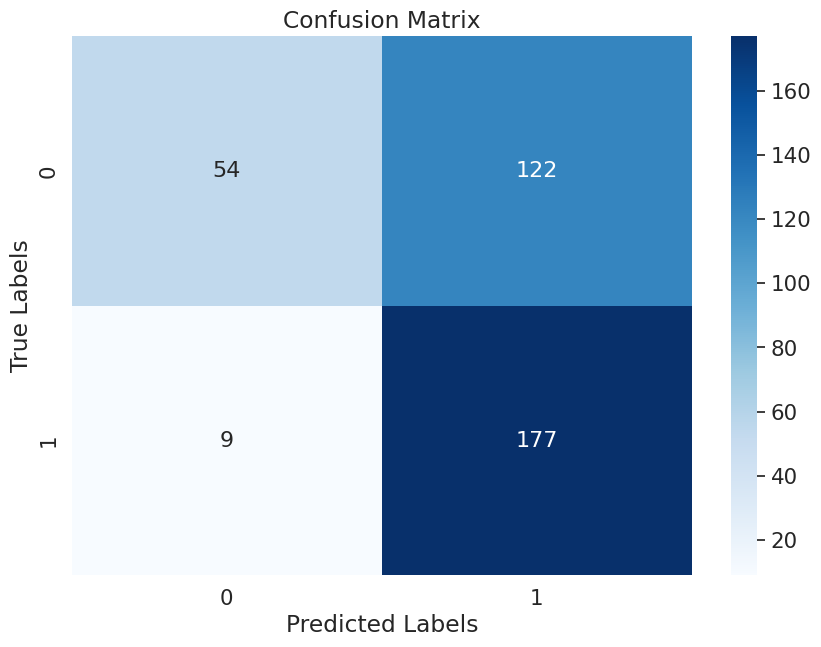

100%|██████████| 3/3 [00:00<00:00, 13.32it/s]


              precision    recall  f1-score   support

           0       0.42      0.10      0.16        50
           1       0.41      0.82      0.54        38

    accuracy                           0.41        88
   macro avg       0.41      0.46      0.35        88
weighted avg       0.41      0.41      0.33        88



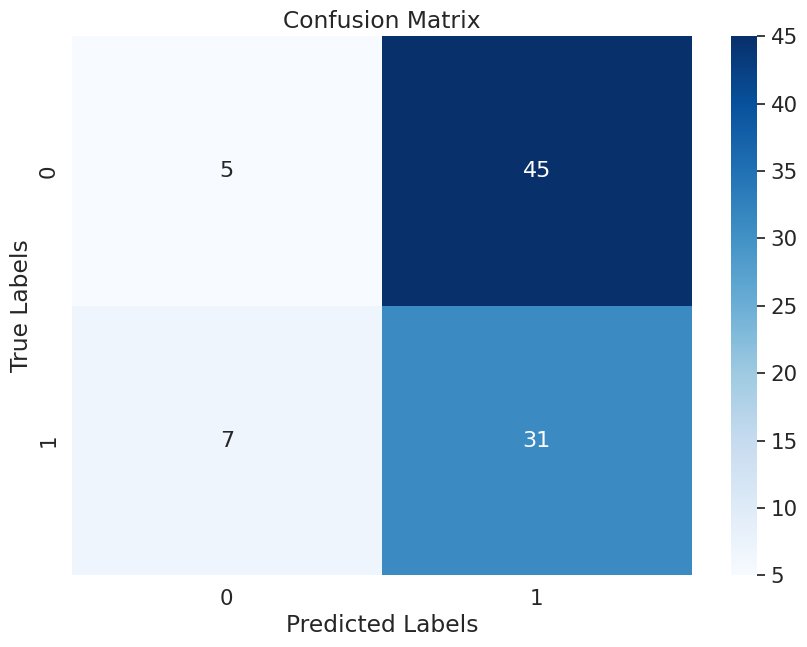

In [2]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import wandb

class COPADataset(Dataset):
    def __init__(self, dataframe, ft_model, tokenizer, lang='mr'):
        self.dataframe = dataframe
        self.ft_model = ft_model
        self.tokenizer = tokenizer
        self.lang = lang

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        premise = self.text_to_embedding(row['premise'])
        choice1 = self.text_to_embedding(row['choice1'])
        choice2 = self.text_to_embedding(row['choice2'])
        label = row['label']

        return {
            'premise': premise,
            'choice1': choice1,
            'choice2': choice2,
            'label': torch.tensor(label, dtype=torch.long)
        }

    def text_to_embedding(self, text):
        tokens = self.tokenizer(text, lang=self.lang)
        embeddings = [self.ft_model.get_word_vector(token) for token in tokens]
        return torch.tensor(embeddings, dtype=torch.float)
    
def collate_fn(batch):
    batch_premise = pad_sequence([item['premise'] for item in batch], batch_first=True, padding_value=0)
    batch_choice1 = pad_sequence([item['choice1'] for item in batch], batch_first=True, padding_value=0)
    batch_choice2 = pad_sequence([item['choice2'] for item in batch], batch_first=True, padding_value=0)
    labels = torch.stack([item['label'] for item in batch])

    return {
        'premise': batch_premise,
        'choice1': batch_choice1,
        'choice2': batch_choice2,
        'label': labels
    }

class ChoiceComparisonModel(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(ChoiceComparisonModel, self).__init__()
        self.lstm = nn.LSTM(300, hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2 * 3, output_dim)  

    def forward(self, premise, choice1, choice2):

        premise_out, _ = self.lstm(premise)
        choice1_out, _ = self.lstm(choice1)
        choice2_out, _ = self.lstm(choice2)

        premise_final = premise_out.mean(dim=1) 
        choice1_final = choice1_out.mean(dim=1) 
        choice2_final = choice2_out.mean(dim=1) 

        combined = torch.cat((premise_final, choice1_final, choice2_final), dim=1)
        logits = self.fc(combined)
        return logits
    
train_dataset = COPADataset(train_df, ft_model, indic_tokenize.trivial_tokenize, lang='mr')
val_dataset = COPADataset(val_df, ft_model, indic_tokenize.trivial_tokenize, lang='mr')
test_dataset = COPADataset(test_df, ft_model, indic_tokenize.trivial_tokenize, lang='mr')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

model_baseline = ChoiceComparisonModel(hidden_dim=128, output_dim=2).to(device)
optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

wandb.init(project='ELMO_FOR_INDIAN_LANGUAGES_GROUP-30', name="Downtask7-Train_baseline_Marathi")

def train(model, train_loader, optimizer, criterion, device):
    model.train() 
    total_loss = 0
    for batch in tqdm(train_loader):
        premise = batch['premise'].to(device)
        choice1 = batch['choice1'].to(device)
        choice2 = batch['choice2'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad() 
        outputs = model(premise, choice1, choice2)  
        loss = criterion(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        total_loss += loss.item() 
        
    wandb.log({"train_loss": total_loss / len(train_loader)})
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def evaluate(model, dataloader, criterion, device):
    model.eval()  
    total_loss = 0
    all_embeddings = []
    all_labels = []
    with torch.no_grad():  
        for batch in tqdm(dataloader):
            premise = batch['premise'].to(device)
            choice1 = batch['choice1'].to(device)
            choice2 = batch['choice2'].to(device)
            labels = batch['label'].to(device)

            outputs = model(premise, choice1, choice2)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_embeddings.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_loss = total_loss / len(dataloader)
    return np.array(all_embeddings), np.array(all_labels)

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model_baseline, train_loader, optimizer_baseline, criterion, device)

# ==========================================================================
train_embeddings, train_labels = evaluate(model_baseline, train_loader, criterion, device)
predicted_labels_train = np.argmax(train_embeddings, axis=1)

print(classification_report(train_labels, predicted_labels_train))
cm = confusion_matrix(train_labels, predicted_labels_train)
plt.figure(figsize=(10, 7)) 
sns.set(font_scale=1.4)  
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap=plt.cm.Blues) 

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ==========================================================================
test_embeddings, test_labels = evaluate(model_baseline, val_loader, criterion, device)
predicted_labels = np.argmax(test_embeddings, axis=1)

print(classification_report(test_labels, predicted_labels))
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7)) 
sns.set(font_scale=1.4)  
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap=plt.cm.Blues) 

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### 1.2 ELMO

train_loss,█▇▆▆▆▅▁▂▁▁
train_loss,0.64896


100%|██████████| 12/12 [00:00<00:00, 15.78it/s]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       176
           1       1.00      1.00      1.00       186

    accuracy                           1.00       362
   macro avg       1.00      1.00      1.00       362
weighted avg       1.00      1.00      1.00       362



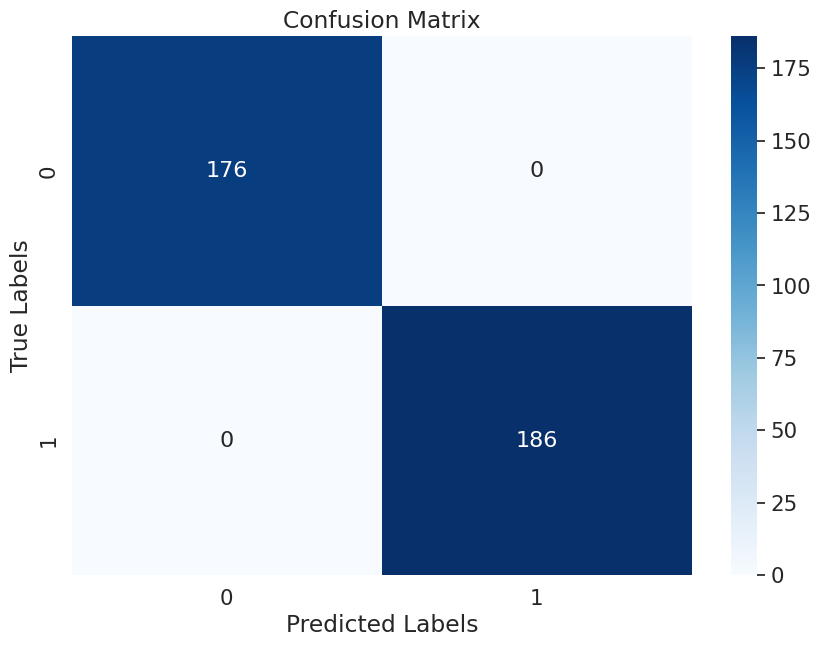

100%|██████████| 3/3 [00:00<00:00, 15.61it/s]


              precision    recall  f1-score   support

           0       0.66      0.50      0.57        50
           1       0.50      0.66      0.57        38

    accuracy                           0.57        88
   macro avg       0.58      0.58      0.57        88
weighted avg       0.59      0.57      0.57        88



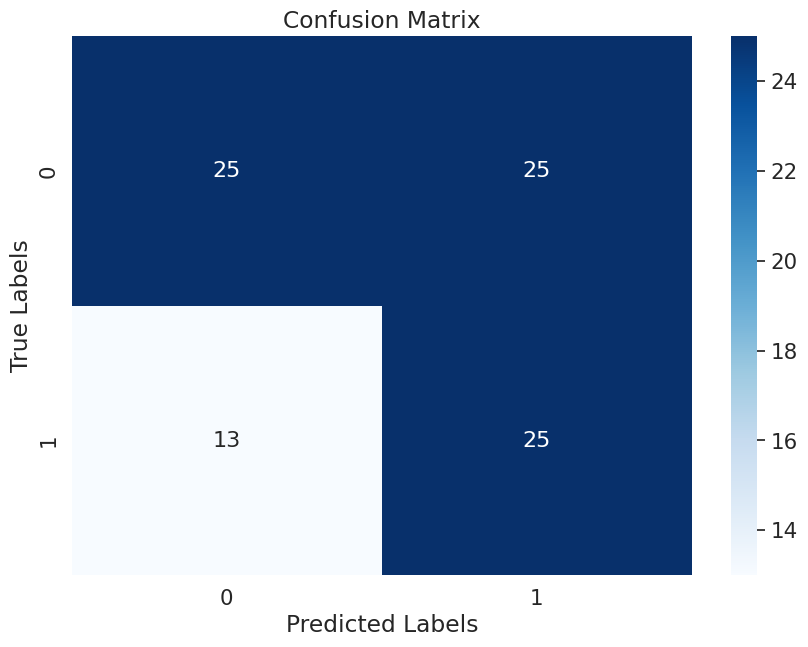

In [3]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import wandb

class COPADataset(Dataset):
    def __init__(self, dataframe, ft_model, tokenizer, lang='mr'):
        self.dataframe = dataframe
        self.ft_model = ft_model
        self.tokenizer = tokenizer
        self.lang = lang

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        premise = self.text_to_embedding(row['premise'])
        choice1 = self.text_to_embedding(row['choice1'])
        choice2 = self.text_to_embedding(row['choice2'])
        label = row['label']

        return {
            'premise': premise,
            'choice1': choice1,
            'choice2': choice2,
            'label': torch.tensor(label, dtype=torch.long)
        }

    def text_to_embedding(self, text):
        tokens = self.tokenizer(text, lang=self.lang)
        embeddings = [self.ft_model.get_word_vector(token) for token in tokens]
        return torch.tensor(embeddings, dtype=torch.float)
    
def collate_fn(batch):
    batch_premise = pad_sequence([item['premise'] for item in batch], batch_first=True, padding_value=0)
    batch_choice1 = pad_sequence([item['choice1'] for item in batch], batch_first=True, padding_value=0)
    batch_choice2 = pad_sequence([item['choice2'] for item in batch], batch_first=True, padding_value=0)
    labels = torch.stack([item['label'] for item in batch])

    return {
        'premise': batch_premise,
        'choice1': batch_choice1,
        'choice2': batch_choice2,
        'label': labels
    }

class ChoiceComparisonModel(nn.Module):
    def __init__(self, elmo_model, hidden_dim, output_dim):
        super(ChoiceComparisonModel, self).__init__()
        self.elmo_model = elmo_model  
        self.lstm = nn.LSTM(300, hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2 * 3, output_dim)  

    def forward(self, premise, choice1, choice2):
        _, _, premise_embeddings = self.elmo_model(premise)
        _, _, choice1_embeddings = self.elmo_model(choice1)
        _, _, choice2_embeddings = self.elmo_model(choice2)

        premise_out, _ = self.lstm(premise_embeddings)
        choice1_out, _ = self.lstm(choice1_embeddings)
        choice2_out, _ = self.lstm(choice2_embeddings)

        premise_final = premise_out.mean(dim=1) 
        choice1_final = choice1_out.mean(dim=1) 
        choice2_final = choice2_out.mean(dim=1) 

        combined = torch.cat((premise_final, choice1_final, choice2_final), dim=1)
        logits = self.fc(combined)
        return logits
    
train_dataset = COPADataset(train_df, ft_model, indic_tokenize.trivial_tokenize, lang='mr')
val_dataset = COPADataset(val_df, ft_model, indic_tokenize.trivial_tokenize, lang='mr')
test_dataset = COPADataset(test_df, ft_model, indic_tokenize.trivial_tokenize, lang='mr')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

model = ChoiceComparisonModel(elmo_model, hidden_dim=128, output_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

wandb.init(project='ELMO_FOR_INDIAN_LANGUAGES_GROUP-30', name="Downtask7-Train_elmo_Marathi")

def train(model, train_loader, optimizer, criterion, device):
    model.train() 
    total_loss = 0
    for batch in tqdm(train_loader):
        premise = batch['premise'].to(device)
        choice1 = batch['choice1'].to(device)
        choice2 = batch['choice2'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad() 
        outputs = model(premise, choice1, choice2)  
        loss = criterion(outputs, labels) 
        loss.backward() 
        optimizer.step() 

        total_loss += loss.item() 
        
    wandb.log({"train_loss": total_loss / len(train_loader)})
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def evaluate(model, dataloader, criterion, device):
    model.eval()  
    total_loss = 0
    all_embeddings = []
    all_labels = []
    with torch.no_grad():  
        for batch in tqdm(dataloader):
            premise = batch['premise'].to(device)
            choice1 = batch['choice1'].to(device)
            choice2 = batch['choice2'].to(device)
            labels = batch['label'].to(device)

            outputs = model(premise, choice1, choice2)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_embeddings.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_loss = total_loss / len(dataloader)
    return np.array(all_embeddings), np.array(all_labels)

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)  

# ==========================================================================
train_embeddings, train_labels = evaluate(model, train_loader, criterion, device)
predicted_labels_train = np.argmax(train_embeddings, axis=1)

print(classification_report(train_labels, predicted_labels_train))
cm = confusion_matrix(train_labels, predicted_labels_train)
plt.figure(figsize=(10, 7)) 
sns.set(font_scale=1.4)  
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap=plt.cm.Blues) 

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ==========================================================================
test_embeddings, test_labels = evaluate(model, val_loader, criterion, device)
predicted_labels = np.argmax(test_embeddings, axis=1)

print(classification_report(test_labels, predicted_labels))
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7)) 
sns.set(font_scale=1.4)  
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap=plt.cm.Blues) 

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### ===========================================================================================